In [68]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
%matplotlib inline

In [2]:
# Load the dataset into Pandas dataframe
ev_car_sales_df = pd.read_csv("resources_j/IEA-EV-dataEV_salesHistoricalCars.csv")
all_car_sales_df = pd.read_csv("resources_j/vehicle_sales_total.csv")
total_registered_and_type_df = pd.read_csv("resources_j/vehicle_type_registered.csv")
early_years_total_registered_and_type_df = pd.read_csv("resources_j/Motor_Vehicle_Registrations__by_vehicle_type_and_state_20240702.csv")
total_registered_full_years_df = pd.read_csv("resources_j/total_registered.csv")


In [3]:
# Calculate percentage of Electric (EV) vehicles
total_registered_and_type_df['% Electric'] = (total_registered_and_type_df['Electric (EV)'] / total_registered_and_type_df['Total Registered']) * 100

# Calculate percentage of Gasoline vehicles
total_registered_and_type_df['% Gasoline'] = (total_registered_and_type_df['Gasoline'] / total_registered_and_type_df['Total Registered']) * 100

In [4]:
total_registered_and_type_df

,Year,Electric (EV),Plug-In Hybrid Electric (PHEV),Hybrid Electric (HEV),Biodiesel,Ethanol/Flex (E85),Compressed Natural Gas (CNG),Propane,Hydrogen,Methanol,Gasoline,Diesel,Unknown Fuel,Total Registered,% Electric,% Gasoline
0,2016,280300,254000,3741600,0,22138300,721600,0,1300,500,224855100,7734000,3000600,262727300,0.106689,85.584977
1,2017,377100,344600,4036000,0,24607700,663100,0,3200,500,227415700,8115800,2789800,268353500,0.140524,84.744824
2,2018,572600,461300,4242400,0,26288400,609200,0,9400,300,229074100,8279800,2668600,272206100,0.210355,84.154653
3,2019,783600,536600,4512900,0,27540700,560700,0,12800,300,231358800,8550900,2601600,276458900,0.283442,83.686508
4,2020,1018900,594400,4813700,0,27997200,521600,0,14200,300,231992200,8860500,2486200,278299200,0.366117,83.360714
5,2021,1454400,786800,5491800,2194100,21244900,40800,7600,11800,0,240699500,7110300,1840200,280882200,0.517797,85.694109
6,2022,2442300,1012400,6291800,2526100,20906700,25600,6600,14900,0,241372900,7156900,1752800,283509000,0.861454,85.137650


In [5]:
ev_car_sales_df.head(10)

,region,category,parameter,mode,powertrain,year,unit,value
0,Australia,Historical,EV sales share,Cars,EV,2011,percent,0.00650
1,Australia,Historical,EV stock share,Cars,EV,2011,percent,0.00039
2,Australia,Historical,EV sales,Cars,BEV,2011,Vehicles,49.00000
3,Australia,Historical,EV stock,Cars,BEV,2011,Vehicles,49.00000
4,Australia,Historical,EV stock,Cars,BEV,2012,Vehicles,220.00000
5,Australia,Historical,EV sales,Cars,BEV,2012,Vehicles,170.00000
6,Australia,Historical,EV stock share,Cars,EV,2012,percent,0.00240
7,Australia,Historical,EV sales share,Cars,EV,2012,percent,0.03000
8,Australia,Historical,EV stock,Cars,PHEV,2012,Vehicles,80.00000
9,Australia,Historical,EV sales,Cars,PHEV,2012,Vehicles,80.00000


In [6]:
# Filtering DataFrame to include only rows where region is 'USA' 
ev_car_sales_df = ev_car_sales_df[ev_car_sales_df['region'] == 'USA']

In [7]:
# only need powertrain is EV and remove category
# ev_car_sales_df = ev_car_sales_df[ev_car_sales_df['powertrain'] == 'BEV']
ev_car_sales_df = ev_car_sales_df.drop(columns=['category'])

In [8]:
ev_car_sales_df.head(5)
# ev_car_sales_df.tail(20)

,region,parameter,mode,powertrain,year,unit,value
3500,USA,EV sales,Cars,BEV,2010,Vehicles,1200.00000
3501,USA,EV stock,Cars,BEV,2010,Vehicles,3800.00000
3502,USA,Oil displacement Mbd,Cars,EV,2010,Milion barrels per day,0.00016
3503,USA,"Oil displacement, million lge",Cars,EV,2010,"Oil displacement, million lge",9.40000
3504,USA,Electricity demand,Cars,EV,2010,GWh,96.00000


In [9]:
# Multiply the sales column by 1000
all_car_sales_df['sales'] = all_car_sales_df['sales'] * 1000

In [10]:
all_car_sales_df.head()

,Year,sales
0,2011,12741800.0
1,2012,14433200.0
2,2013,16452200.0
3,2014,15530100.0
4,2015,17408000.0


In [11]:
# Filter the first DataFrame to include only EV or BEV sales data
ev_sales_df = ev_car_sales_df[(ev_car_sales_df['parameter'] == 'EV sales') & (ev_car_sales_df['powertrain'].isin(['EV', 'BEV']))][['year', 'value']]

# Merge the EV sales data with the total sales data
combined_sales_df = pd.merge(ev_sales_df, all_car_sales_df, left_on='year', right_on='Year', how='right')

# Rename columns
combined_sales_df = combined_sales_df.rename(columns={'value': 'Battery EV sales', 'sales': 'Total sales'})

# Drop unnecessary columns
combined_sales_df = combined_sales_df.drop(columns=['Year'])
combined_sales_df = combined_sales_df.rename(columns={'year': 'Year'})

In [12]:
# Calculate cumulative sum of Battery EV sales to include for estimate Electric (EV) for the missing years
combined_sales_df['Electric (EV)'] = combined_sales_df['Battery EV sales'].cumsum()
combined_sales_df

,Year,Battery EV sales,Total sales,Electric (EV)
0,2011,9800.0,12741800.0,9800.0
1,2012,15000.0,14433200.0,24800.0
2,2013,48000.0,16452200.0,72800.0
3,2014,63000.0,15530100.0,135800.0
4,2015,71000.0,17408000.0,206800.0
5,2016,87000.0,17477300.0,293800.0
6,2017,100000.0,17150000.0,393800.0
7,2018,240000.0,17224900.0,633800.0
8,2019,240000.0,16961100.0,873800.0
9,2020,230000.0,14471800.0,1103800.0


In [13]:
combined_sales_df

,Year,Battery EV sales,Total sales,Electric (EV)
0,2011,9800.0,12741800.0,9800.0
1,2012,15000.0,14433200.0,24800.0
2,2013,48000.0,16452200.0,72800.0
3,2014,63000.0,15530100.0,135800.0
4,2015,71000.0,17408000.0,206800.0
5,2016,87000.0,17477300.0,293800.0
6,2017,100000.0,17150000.0,393800.0
7,2018,240000.0,17224900.0,633800.0
8,2019,240000.0,16961100.0,873800.0
9,2020,230000.0,14471800.0,1103800.0


In [14]:
early_years_total_registered_and_type_df.head()

,Year,State,Light Vehicles,Truck,Bus,Motorcycle
0,2011,Alabama,2307668,12373,2364601,127301.0
1,2011,Alaska,215688,2346,508900,31020.0
2,2011,Arizona,2363015,11759,2555552,178928.0
3,2011,Arkansas,1021817,3350,1346842,76301.0
4,2011,California,14549841,36876,13771330,818650.0


In [15]:
print("Columns in DataFrame:", early_years_total_registered_and_type_df.columns)

Columns in DataFrame: Index(['Year', 'State', 'Light Vehicles', ' Truck', ' Bus', ' Motorcycle'], dtype='object')


In [16]:
# early_years_total_registered_and_type_df = early_years_total_registered_and_type_df.drop(columns=[' Truck', ' Bus', ' Motorcycle'])
early_years_total_registered_and_type_df = early_years_total_registered_and_type_df.drop(columns=[' Bus', ' Motorcycle'])

In [17]:
# early_years_total_registered_and_type_df.head()
grouped_sum = early_years_total_registered_and_type_df.groupby('Year').sum(numeric_only=True)


In [18]:
grouped_sum = grouped_sum.reset_index()
grouped_sum

,Year,Light Vehicles,Truck
0,2011,125656528,666064
1,2012,111289910,764509
2,2013,113676346,864550
3,2014,113898843,872028
4,2015,112864228,888907
5,2016,112961266,976161
6,2018,111242132,992151


In [19]:
# Multiply the Total registered column by 1000
total_registered_full_years_df['Total registered'] = total_registered_full_years_df['Total registered'] * 1000
total_registered_full_years_df['Light Vehicles'] = total_registered_full_years_df['Light Vehicles'] * 1000
total_registered_full_years_df

,Year,Total registered,Light Vehicles
0,2011,253108390.0,NaN
1,2012,253639390.0,NaN
2,2013,255876820.0,NaN
3,2014,260350940.0,NaN
4,2015,263610220.0,NaN
5,2016,268799080.0,NaN
6,2017,272480900.0,NaN
7,2018,273602100.0,NaN
8,2019,276491170.0,NaN
9,2020,275936370.0,NaN


In [20]:
percentage_light_vehicles_2023 = total_registered_full_years_df.loc[total_registered_full_years_df['Year'] == 2023, 'Light Vehicles'].values[0] / total_registered_full_years_df.loc[total_registered_full_years_df['Year'] == 2023, 'Total registered'].values[0]
# print(percentage_light_vehicles_2023)

# Fill in the missing values in the Light Vehicles column
total_registered_full_years_df['Light Vehicles'] = total_registered_full_years_df.apply(
    lambda row: row['Total registered'] * percentage_light_vehicles_2023 if pd.isna(row['Light Vehicles']) else row['Light Vehicles'],
    axis=1
)
total_registered_full_years_df['Light Vehicles'] = total_registered_full_years_df['Light Vehicles'].astype(float).map('{:.1f}'.format)
total_registered_full_years_df

,Year,Total registered,Light Vehicles
0,2011,253108390.0,247405774.6
1,2012,253639390.0,247924811.0
2,2013,255876820.0,250111831.0
3,2014,260350940.0,254485147.6
4,2015,263610220.0,257670994.9
5,2016,268799080.0,262742948.2
6,2017,272480900.0,266341815.6
7,2018,273602100.0,267437754.6
8,2019,276491170.0,270261732.9
9,2020,275936370.0,269719432.7


In [21]:
merged_final_registered_df = pd.merge(total_registered_full_years_df, total_registered_and_type_df, on='Year', how='left')
# merged_final_registered_df

In [22]:
print("Columns in DataFrame:", merged_final_registered_df.columns)

Columns in DataFrame: Index(['Year', 'Total registered', 'Light Vehicles', 'Electric (EV)',
       'Plug-In Hybrid Electric (PHEV)', 'Hybrid Electric (HEV)', 'Biodiesel',
       'Ethanol/Flex (E85)', 'Compressed Natural Gas (CNG)', 'Propane',
       'Hydrogen', 'Methanol', 'Gasoline', 'Diesel', 'Unknown Fuel',
       'Total Registered', '% Electric', '% Gasoline'],
      dtype='object')


In [23]:
# drop duplicate column
merged_final_registered_df = merged_final_registered_df.drop(columns=['Total Registered'])
merged_final_registered_df

,Year,Total registered,Light Vehicles,Electric (EV),Plug-In Hybrid Electric (PHEV),Hybrid Electric (HEV),Biodiesel,Ethanol/Flex (E85),Compressed Natural Gas (CNG),Propane,Hydrogen,Methanol,Gasoline,Diesel,Unknown Fuel,% Electric,% Gasoline
0,2011,253108390.0,247405774.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2012,253639390.0,247924811.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013,255876820.0,250111831.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2014,260350940.0,254485147.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,263610220.0,257670994.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2016,268799080.0,262742948.2,280300.0,254000.0,3741600.0,0.0,22138300.0,721600.0,0.0,1300.0,500.0,224855100.0,7734000.0,3000600.0,0.106689,85.584977
6,2017,272480900.0,266341815.6,377100.0,344600.0,4036000.0,0.0,24607700.0,663100.0,0.0,3200.0,500.0,227415700.0,8115800.0,2789800.0,0.140524,84.744824
7,2018,273602100.0,267437754.6,572600.0,461300.0,4242400.0,0.0,26288400.0,609200.0,0.0,9400.0,300.0,229074100.0,8279800.0,2668600.0,0.210355,84.154653
8,2019,276491170.0,270261732.9,783600.0,536600.0,4512900.0,0.0,27540700.0,560700.0,0.0,12800.0,300.0,231358800.0,8550900.0,2601600.0,0.283442,83.686508
9,2020,275936370.0,269719432.7,1018900.0,594400.0,4813700.0,0.0,27997200.0,521600.0,0.0,14200.0,300.0,231992200.0,8860500.0,2486200.0,0.366117,83.360714


In [24]:
# Interpolate the remaining missing % Electric and % Gasoline values
# merged_final_registered_df['% Electric'] = merged_final_registered_df['% Electric'].interpolate()
# merged_final_registered_df['% Gasoline'] = merged_final_registered_df['% Gasoline'].interpolate()

# Calculate estimated Gasoline vehicles for the missing years
# merged_final_registered_df['Estimated Gasoline'] = (merged_final_registered_df['Total Registered'] * merged_final_registered_df['% Gasoline']) / 100



In [25]:
merged_final_registered_df

,Year,Total registered,Light Vehicles,Electric (EV),Plug-In Hybrid Electric (PHEV),Hybrid Electric (HEV),Biodiesel,Ethanol/Flex (E85),Compressed Natural Gas (CNG),Propane,Hydrogen,Methanol,Gasoline,Diesel,Unknown Fuel,% Electric,% Gasoline
0,2011,253108390.0,247405774.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2012,253639390.0,247924811.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013,255876820.0,250111831.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2014,260350940.0,254485147.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,263610220.0,257670994.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2016,268799080.0,262742948.2,280300.0,254000.0,3741600.0,0.0,22138300.0,721600.0,0.0,1300.0,500.0,224855100.0,7734000.0,3000600.0,0.106689,85.584977
6,2017,272480900.0,266341815.6,377100.0,344600.0,4036000.0,0.0,24607700.0,663100.0,0.0,3200.0,500.0,227415700.0,8115800.0,2789800.0,0.140524,84.744824
7,2018,273602100.0,267437754.6,572600.0,461300.0,4242400.0,0.0,26288400.0,609200.0,0.0,9400.0,300.0,229074100.0,8279800.0,2668600.0,0.210355,84.154653
8,2019,276491170.0,270261732.9,783600.0,536600.0,4512900.0,0.0,27540700.0,560700.0,0.0,12800.0,300.0,231358800.0,8550900.0,2601600.0,0.283442,83.686508
9,2020,275936370.0,269719432.7,1018900.0,594400.0,4813700.0,0.0,27997200.0,521600.0,0.0,14200.0,300.0,231992200.0,8860500.0,2486200.0,0.366117,83.360714


In [26]:
# Set 'Year' as index
combined_sales_df.set_index('Year', inplace=True)
merged_final_registered_df.set_index('Year', inplace=True)

# Combine the 'Electric (EV)' column from df1 into df2 to fill NaN values
merged_final_registered_df['Electric (EV)'] = merged_final_registered_df['Electric (EV)'].combine_first(combined_sales_df['Electric (EV)'])

# Reset index if needed
combined_sales_df.reset_index(inplace=True)
merged_final_registered_df.reset_index(inplace=True)

In [27]:
merged_final_registered_df['% Electric'] = (merged_final_registered_df['Electric (EV)'] / merged_final_registered_df['Total registered']) * 100
merged_final_registered_df

,Year,Total registered,Light Vehicles,Electric (EV),Plug-In Hybrid Electric (PHEV),Hybrid Electric (HEV),Biodiesel,Ethanol/Flex (E85),Compressed Natural Gas (CNG),Propane,Hydrogen,Methanol,Gasoline,Diesel,Unknown Fuel,% Electric,% Gasoline
0,2011,253108390.0,247405774.6,9800.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.003872,NaN
1,2012,253639390.0,247924811.0,24800.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.009778,NaN
2,2013,255876820.0,250111831.0,72800.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.028451,NaN
3,2014,260350940.0,254485147.6,135800.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.052160,NaN
4,2015,263610220.0,257670994.9,206800.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.078449,NaN
5,2016,268799080.0,262742948.2,280300.0,254000.0,3741600.0,0.0,22138300.0,721600.0,0.0,1300.0,500.0,224855100.0,7734000.0,3000600.0,0.104279,85.584977
6,2017,272480900.0,266341815.6,377100.0,344600.0,4036000.0,0.0,24607700.0,663100.0,0.0,3200.0,500.0,227415700.0,8115800.0,2789800.0,0.138395,84.744824
7,2018,273602100.0,267437754.6,572600.0,461300.0,4242400.0,0.0,26288400.0,609200.0,0.0,9400.0,300.0,229074100.0,8279800.0,2668600.0,0.209282,84.154653
8,2019,276491170.0,270261732.9,783600.0,536600.0,4512900.0,0.0,27540700.0,560700.0,0.0,12800.0,300.0,231358800.0,8550900.0,2601600.0,0.283409,83.686508
9,2020,275936370.0,269719432.7,1018900.0,594400.0,4813700.0,0.0,27997200.0,521600.0,0.0,14200.0,300.0,231992200.0,8860500.0,2486200.0,0.369252,83.360714


In [28]:
# Calculate the average % Gasoline excluding NaN values
avg_gasoline_percent = merged_final_registered_df['% Gasoline'].mean()

# Fill NaN values in the % Gasoline column with the average
merged_final_registered_df['% Gasoline'].fillna(avg_gasoline_percent, inplace=True)

# Fill 'Gasoline' column where it's missing using '% Gasoline' and 'Total registered'
merged_final_registered_df['Gasoline'] = merged_final_registered_df.apply(
    lambda row: row['Total registered'] * (row['% Gasoline'] / 100) if pd.isnull(row['Gasoline']) else row['Gasoline'], axis=1
)
merged_final_registered_df['Gasoline'] = merged_final_registered_df['Gasoline'].astype(float).map('{:.1f}'.format)
merged_final_registered_df

,Year,Total registered,Light Vehicles,Electric (EV),Plug-In Hybrid Electric (PHEV),Hybrid Electric (HEV),Biodiesel,Ethanol/Flex (E85),Compressed Natural Gas (CNG),Propane,Hydrogen,Methanol,Gasoline,Diesel,Unknown Fuel,% Electric,% Gasoline
0,2011,253108390.0,247405774.6,9800.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,214188793.6,NaN,NaN,0.003872,84.623348
1,2012,253639390.0,247924811.0,24800.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,214638143.6,NaN,NaN,0.009778,84.623348
2,2013,255876820.0,250111831.0,72800.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,216531531.8,NaN,NaN,0.028451,84.623348
3,2014,260350940.0,254485147.6,135800.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,220317681.9,NaN,NaN,0.052160,84.623348
4,2015,263610220.0,257670994.9,206800.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,223075793.7,NaN,NaN,0.078449,84.623348
5,2016,268799080.0,262742948.2,280300.0,254000.0,3741600.0,0.0,22138300.0,721600.0,0.0,1300.0,500.0,224855100.0,7734000.0,3000600.0,0.104279,85.584977
6,2017,272480900.0,266341815.6,377100.0,344600.0,4036000.0,0.0,24607700.0,663100.0,0.0,3200.0,500.0,227415700.0,8115800.0,2789800.0,0.138395,84.744824
7,2018,273602100.0,267437754.6,572600.0,461300.0,4242400.0,0.0,26288400.0,609200.0,0.0,9400.0,300.0,229074100.0,8279800.0,2668600.0,0.209282,84.154653
8,2019,276491170.0,270261732.9,783600.0,536600.0,4512900.0,0.0,27540700.0,560700.0,0.0,12800.0,300.0,231358800.0,8550900.0,2601600.0,0.283409,83.686508
9,2020,275936370.0,269719432.7,1018900.0,594400.0,4813700.0,0.0,27997200.0,521600.0,0.0,14200.0,300.0,231992200.0,8860500.0,2486200.0,0.369252,83.360714


<Axes: title={'center': 'Total Registered Cars by Year'}, xlabel='Year', ylabel='Total registered'>

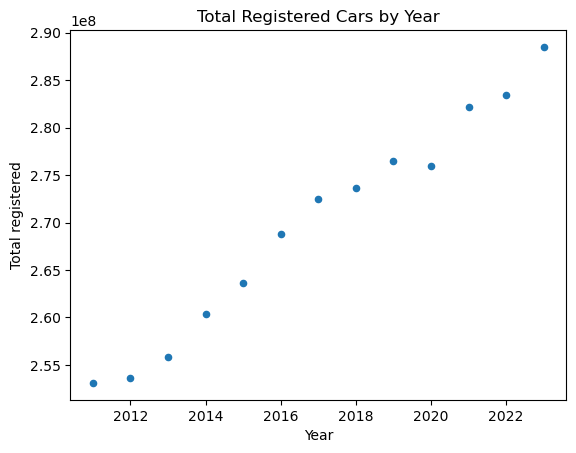

In [70]:
# Create a scatter plot with the total cars by year
total_plot = merged_final_registered_df.plot.scatter(
    x="Year",
    y="Total registered",
    title="Total Registered Cars by Year"
)
total_plot

<Axes: title={'center': 'Registered Electric Cars by Year'}, xlabel='Year', ylabel='Electric (EV)'>

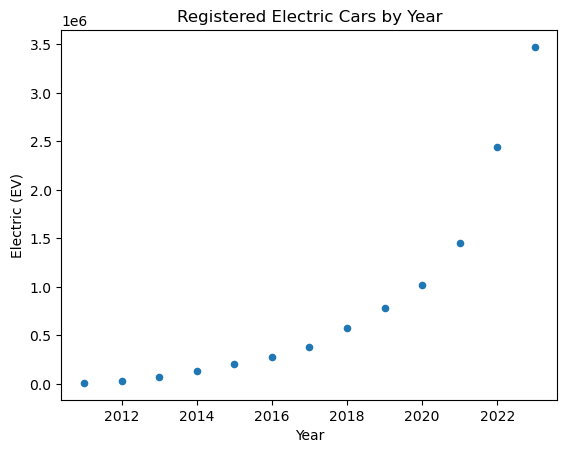

In [71]:
# Create a scatter plot with the electric cars by year
elec_plot = merged_final_registered_df.plot.scatter(
    x="Year",
    y="Electric (EV)",
    title= "Registered Electric Cars by Year"
)
elec_plot

<Axes: title={'center': 'Registered Gasoline Light Duty Cars by Year'}, xlabel='Year', ylabel='Gasoline'>

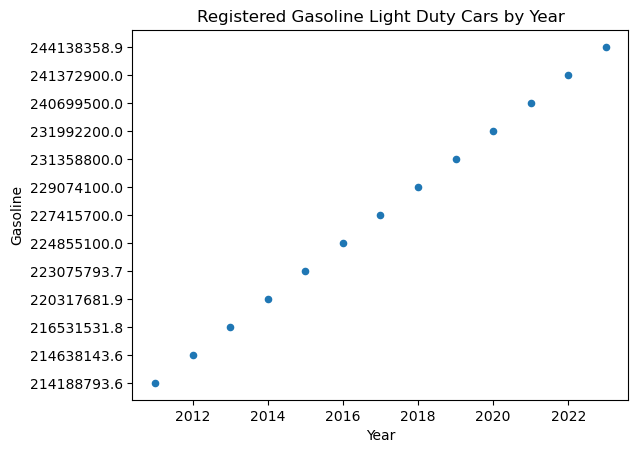

In [72]:
# Create a scatter plot with the Gasoline cars by year
Gasoline_plot = merged_final_registered_df.plot.scatter(
    x="Year",
    y="Gasoline",
    title= "Registered Gasoline Light Duty Cars by Year"
)
Gasoline_plot

In [29]:
# prophet model (unused rn)
merged_final_registered_df_prophet = merged_final_registered_df
merged_final_registered_df_prophet['ds'] = pd.to_datetime(merged_final_registered_df_prophet['Year'], format='%Y')

# Preparing datasets for Prophet
df_gasoline = merged_final_registered_df_prophet[['ds', 'Gasoline']].rename(columns={'Gasoline': 'y'})
df_electric = merged_final_registered_df_prophet[['ds', 'Electric (EV)']].rename(columns={'Electric (EV)': 'y'})
df_gasoline

,ds,y
0,2011-01-01,214188793.6
1,2012-01-01,214638143.6
2,2013-01-01,216531531.8
3,2014-01-01,220317681.9
4,2015-01-01,223075793.7
5,2016-01-01,224855100.0
6,2017-01-01,227415700.0
7,2018-01-01,229074100.0
8,2019-01-01,231358800.0
9,2020-01-01,231992200.0


In [31]:
# random forest model
pd.options.display.float_format = '{:.0f}'.format
merged_final_registered_df_rf = merged_final_registered_df
# Define the features and target
X = merged_final_registered_df_rf[['Year', '% Electric', '% Gasoline']]
y_total = merged_final_registered_df_rf['Total registered']
y_gasoline = merged_final_registered_df_rf['Gasoline']
y_electric = merged_final_registered_df_rf['Electric (EV)']

In [62]:
# Train the Random Forest models
model_total = RandomForestRegressor(n_estimators=100, random_state=42)
model_total.fit(X, y_total)

model_gasoline = RandomForestRegressor(n_estimators=100, random_state=42)
model_gasoline.fit(X, y_gasoline)

model_electric = RandomForestRegressor(n_estimators=100, random_state=42)
model_electric.fit(X, y_electric)

np.set_printoptions(suppress=True, precision=8)
# Create future feature dataframe until 2050
future_years = np.arange(2024, 2051)
future_percent_electric = np.linspace(merged_final_registered_df_rf['% Electric'].iloc[-1], 100, len(future_years))
future_percent_gasoline = np.linspace(merged_final_registered_df_rf['% Gasoline'].iloc[-1], 1, len(future_years))

In [63]:
future_features = np.column_stack((future_years, future_percent_electric, future_percent_gasoline))
np.set_printoptions(suppress=True, precision=8)

# Predict future values
pred_total = model_total.predict(future_features)
pred_gasoline = model_gasoline.predict(future_features)
pred_electric = model_electric.predict(future_features)


pred_total = np.round(pred_total, 0)

# Adjust predictions to ensure gasoline vehicles reach 1% by 2050
total_vehicles_2050 = pred_total[-1]
pred_gasoline = np.linspace(pred_gasoline[0], total_vehicles_2050 * 0.01, len(pred_gasoline))

# Combine historical and predicted data for plotting
years_combined = np.concatenate((merged_final_registered_df_rf['Year'], future_years))
total_combined = np.concatenate((merged_final_registered_df_rf['Total registered'], pred_total))
gasoline_combined = np.concatenate((merged_final_registered_df_rf['Gasoline'], pred_gasoline))
electric_combined = np.concatenate((merged_final_registered_df_rf['Electric (EV)'], pred_electric))


/Users/jasoncampbell/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/jasoncampbell/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/jasoncampbell/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


TypeError: 'value' must be an instance of str or bytes, not a float

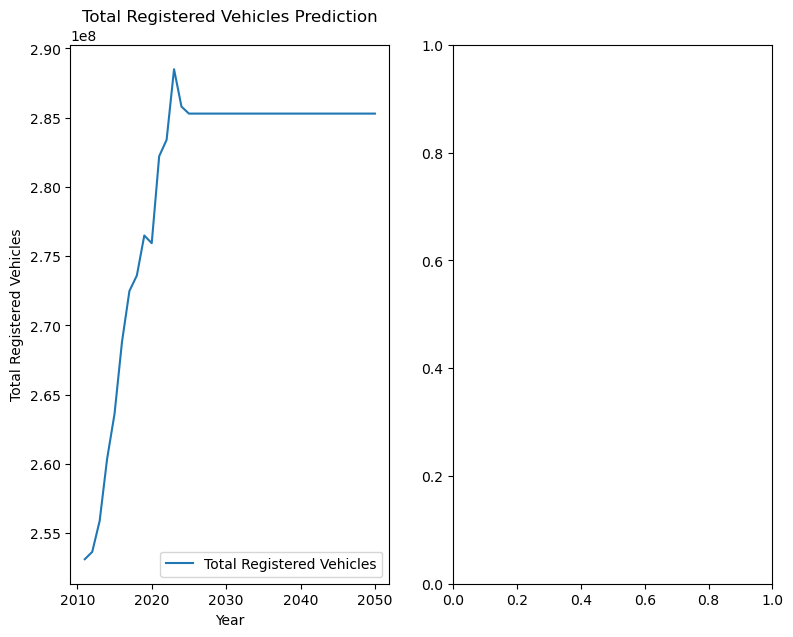

In [67]:
# Plotting the results
plt.figure(figsize=(14, 7))

plt.subplot(1, 3, 1)
plt.plot(years_combined, total_combined, label='Total Registered Vehicles')
plt.xlabel('Year')
plt.ylabel('Total Registered Vehicles')
plt.title('Total Registered Vehicles Prediction')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(years_combined, gasoline_combined, label='Gasoline Vehicles', color='orange')
plt.xlabel('Year')
plt.ylabel('Gasoline Vehicles')
plt.title('Gasoline Vehicles Prediction')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(years_combined, electric_combined, label='Electric Vehicles', color='green')
plt.xlabel('Year')
plt.ylabel('Electric Vehicles')
plt.title('Electric Vehicles Prediction')
plt.legend()

plt.tight_layout()
plt.show()